In [28]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [29]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import imutils
import matplotlib.pyplot as plt
import cv2

In [30]:
from keras.models import load_model
new_model = load_model('/content/gdrive/MyDrive/refined_dataset/log/VKuch to kaho 10.h5')

In [31]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName
		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()
	def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.model.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
	def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
		gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
		# record operations for automatic differentiation
		with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]
		# use automatic differentiation to compute the gradients
		grads = tape.gradient(loss, convOutputs)
		# compute the guided gradients
		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]
		# compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
		# grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
		return heatmap
	def overlay_heatmap(self, heatmap, image, alpha=0.5,
		colormap=cv2.COLORMAP_VIRIDIS):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
		return (heatmap, output)

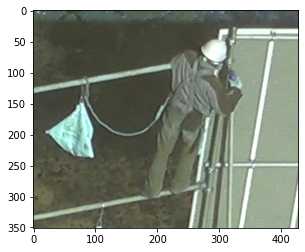

In [49]:
# /content/gdrive/MyDrive/11-9 dataset/test/safe. (106).png
filename = '/content/gdrive/MyDrive/11-8Dataset/test/safe. (107).png'
orignal = cv2.imread(filename)
plt.imshow(orignal)
plt.show()

In [50]:
orig = cv2.cvtColor(orignal, cv2.COLOR_BGR2RGB)
resized = cv2.resize(orig, (400,400))
dataXG = np.array(resized) / 255.0
dataXG = np.expand_dims(dataXG, axis=0)

In [51]:
preds = new_model.predict(dataXG)
i = np.argmax(preds[0])
print(i, preds)

0 [[0.99378985 0.00621016]]


In [52]:
new_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 406, 406, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 200, 200, 64) 9472        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
batch_normalization_91 (BatchNo (None, 200, 200, 64) 256         conv2d_88[0][0]                  
____________________________________________________________________________________________

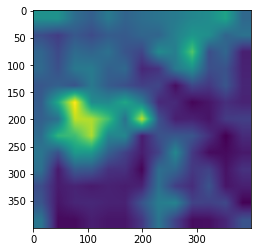

In [53]:
# Compute the heatmap based on step 3
cam = GradCAM(model=new_model, classIdx=i, layerName='add_32') # find the last 4d shape "mixed10" in this case
heatmap = cam.compute_heatmap(dataXG)
#show the calculated heatmap
plt.imshow(heatmap)
plt.show()

(351, 428, 3) (351, 428, 3)


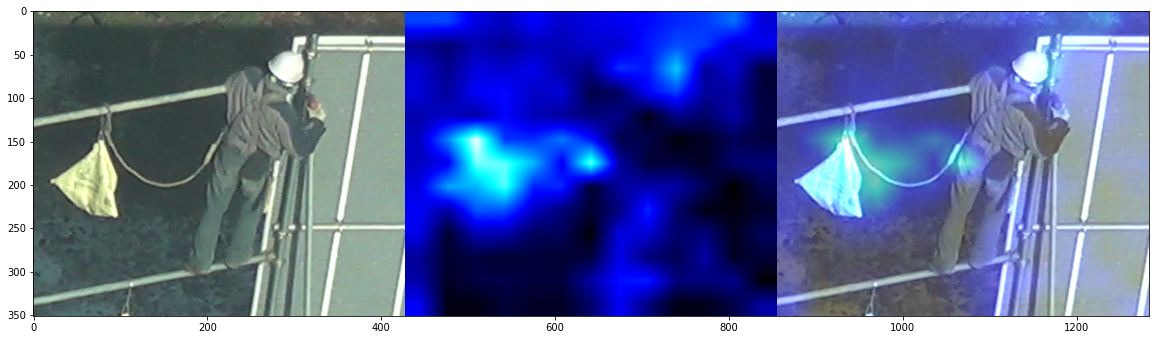

In [54]:
# Old fashioned way to overlay a transparent heatmap onto original image, the same as above
heatmapY = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
heatmapY = cv2.applyColorMap(heatmapY, cv2.COLORMAP_HOT)  # COLORMAP_JET, COLORMAP_VIRIDIS, COLORMAP_HOT
imageY = cv2.addWeighted(heatmapY, 0.5, orignal, 1.0, 0)
print(heatmapY.shape, orig.shape)
# draw the orignal x-ray, the heatmap, and the overlay together
output = np.hstack([orig, heatmapY, imageY])
fig, ax = plt.subplots(figsize=(20, 18))
ax.imshow(np.random.rand(1, 99), interpolation='nearest')
plt.imshow(output)
plt.show()